In [41]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [42]:
iris = load_iris()

X = iris["data"][:, 2:]
y = iris["target"]

tree_clf = DecisionTreeClassifier(max_depth = 2)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [43]:
from sklearn.tree import export_graphviz

In [44]:
export_graphviz(
                tree_clf,
                out_file = ("iris_tree.dot"),
                feature_names = iris.feature_names[2:],
                class_names = iris.target_names,
                rounded = True,
                filled = True)

### Important

One of the many qualities of Decision Trees is that they require very little data preparation. In particular, they don’t require
feature scaling or centering at all.

In [45]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [46]:
tree_clf.predict([[5, 1.5]])

array([1])

## Exercise 7. - Hands on Machine Learning book

Train and fine-tune a Decision Tree for the moons dataset.

a. Generate a moons dataset using make_moons(n_samples=10000, noise=0.4).

b. Split it into a training set and a test set using train_test_split().

c. Use grid search with cross-validation (with the help of the GridSearchCV class) to find good
hyperparameter values for a DecisionTreeClassifier. Hint: try various values for
max_leaf_nodes.

d. Train it on the full training set using these hyperparameters, and measure your model’s
performance on the test set. You should get roughly 85% to 87% accuracy.


In [47]:
from sklearn.datasets import make_moons

In [48]:
X, y = make_moons(n_samples = 10000, noise = 0.4)

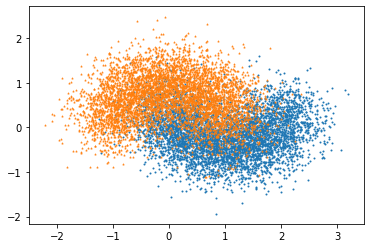

In [49]:
import matplotlib.pyplot as plt

plt.plot(kind = "scatter")
plt.scatter(X[y == 1][:,0], X[y==1][:,1], s = 1, marker = "o")
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], s = 1, marker = "^")

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [51]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "min_samples_split": [2, 3, 4],
    "max_leaf_nodes": list(range(2, 100))
}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs = -1, verbose = 1, cv = 3)
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:    3.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16

In [52]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=16,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [53]:
from sklearn.metrics import accuracy_score

accuracy_score(grid_search_cv.predict(X_test), y_test)

0.8633333333333333

## Exercise 8 - Hands On Machine Learning book

Grow a forest.
a. Continuing the previous exercise, generate 1,000 subsets of the training set, each containing 100
instances selected randomly. Hint: you can use Scikit-Learn’s ShuffleSplit class for this.

b. Train one Decision Tree on each subset, using the best hyperparameter values found above.
Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets,
these Decision Trees will likely perform worse than the first Decision Tree, achieving only
about 80% accuracy.

c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision
Trees, and keep only the most frequent prediction (you can use SciPy’s mode() function for
this). This gives you majority-vote predictions over the test set.

d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your
first model (about 0.5 to 1.5% higher). Congratulations, you have trained a Random Forest
classifier!

In [54]:
from sklearn.model_selection import ShuffleSplit

In [55]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)

for mini_train_index, mini_test_index in rs.split(X_train):
    
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [57]:
from sklearn.base import clone
import numpy as np

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.7966426666666666

In [58]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

Y_pred

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [59]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

In [60]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.8683333333333333